In [58]:
import os
import yaml
import pydub
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import random 
from utils.riffusion_utils import audio_array_to_image
from utils.slakh_utils import get_instrument_str, get_stem_frames, 
from cnet_riff_preprocessing import create_prompt_file, append_to_prompt_file, generate_and_save_control
import cv2

## PARAMETERS 
# sampling rate 
fs = 44100

# define some options 
# define some options 
opt = {}
opt["fs"] = 44100
# opt control methods: "fullspec", "canny", "thresh", "bpf"
opt["control_methods"] = ["fullspec", "canny", "sobel", "sobeldenoise"]
opt["data_root"] = os.path.join('slakh-preprocessed')
opt["control_roots"] = [os.path.join(opt["data_root"], "source-"+mthd) for mthd in opt["control_methods"]]
opt["target_root"] = os.path.join(opt["data_root"], 'target')

opt["canny_low_thresh"] = 150
opt["canny_high_thresh"] = 200
opt["denoise_h"] = 15

#TODO: make all directories needed
os.makedirs(opt["data_root"], exist_ok=True)
for control_root in opt["control_roots"]:
    os.makedirs(control_root, exist_ok=True)
os.makedirs(opt["target_root"], exist_ok=True)

# data folder
root_data_dir = os.path.join('../', 'babyslakh_16k')
train_example_dirs = sorted([f for f in os.listdir(root_data_dir) if f != '.DS_Store'])

# initialize prompt file (WILL WIPE DATA)
# create_prompt_file(opt["data_root"])

# TODO: loop it later
song_no = 0
i = song_no
#for i in range(len(train_example_dirs)):
train_example_dir = train_example_dirs[i]

# load metatdata
with open(os.path.join(root_data_dir, train_example_dir, 'metadata.yaml'), 'r') as stream:
    metadata = yaml.safe_load(stream)
    
# get some potentially usefull metadata
overall_gain = metadata['overall_gain']
stem_metadata = metadata['stems']
num_metadata_stems = len(list(stem_metadata.keys()))

# get only the useful info and from metadata
stem_info = dict.fromkeys(stem_metadata.keys(), '')
stems = dict.fromkeys(stem_metadata.keys(), '')
for stem in stem_metadata:
    try:
        # TODO: decide which stems are background (guitar could be melody or background)
        if stem_metadata[stem]['inst_class'] in ["Drums", "Piano", "Bass"]:
            isbgnd = True
        else:
            isbgnd = False

        # update text description for some things
        stem_info[stem] = {"class": stem_metadata[stem]['inst_class'],
                        "instrument": get_instrument_str(stem_metadata[stem]),
                        "background": isbgnd} 
        
        stems[stem] = pydub.AudioSegment.from_file(os.path.join(root_data_dir, train_example_dir, metadata['audio_dir'], f"{stem}.wav"))
        # update frame rate if needed
        if stems[stem].frame_rate != fs:
            stems[stem] = stems[stem].set_frame_rate(fs)
    except:
        stem_info.pop(stem)
        stems.pop(stem)

num_actual_stems = len(list(stems.keys()))
stem_names = list(stems.keys())

print(f"stems in metadata: {num_metadata_stems}")
print(f"loaded stems: {num_actual_stems}")

stems in metadata: 11
loaded stems: 10


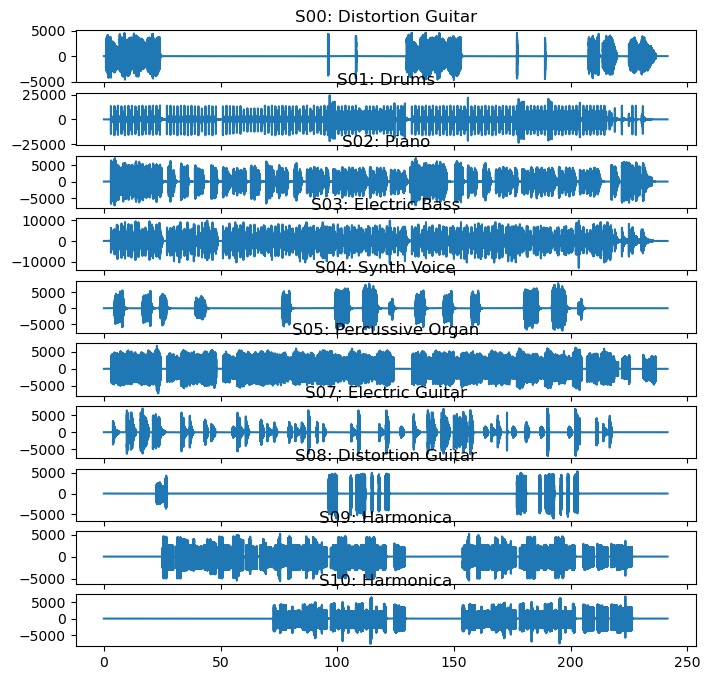

In [48]:
# plot a sample to observe that stems are not on at all times. need to filter which stems to choose from for generation in each window.
fig, axs = plt.subplots(num_actual_stems, 1, figsize=(8, 8), sharex=True)
for j in range(num_actual_stems):
    # get stem
    stem_name = stem_names[j]
    segment = stems[stem_name]
    # get samples and time vec as numpy array
    samples = np.frombuffer(segment.raw_data, dtype=np.int16)
    times = np.arange(0, len(samples)) / fs
    stem_instrument = stem_info[stem_name]["instrument"]
    axs[j].plot(times, samples)
    axs[j].set_title(f"{stem_name}: {stem_instrument}")

In [3]:
# mixing example

viable_stems = stem_names[1:4]

mix = stems[viable_stems[0]]
for stem in viable_stems[1:]:
    mix = mix.overlay(stems[stem])

mix

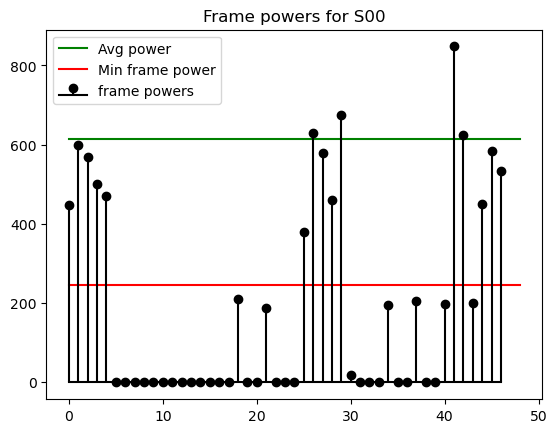

In [4]:
## demonstrate frame selection. accept everything above min_frame_power
j = 0
stem_name = stem_names[j]
segment = stems[stem_name]

overlap = 0
frame_seconds = 5.110 # length of frame
min_power_prop = 0.4

# get samples and time vec as numpy array
samples = np.frombuffer(segment.raw_data, dtype=np.int16)

# get power for samples 
stem_power = np.mean(np.square(samples[(samples != 0)]))

# get number of frames in audio
num_samples_per_segment = int(frame_seconds * fs)
hop_length = int(num_samples_per_segment*(1-overlap))

frames = librosa.util.frame(samples, frame_length=num_samples_per_segment, hop_length=hop_length).T
num_frames = frames.shape[0]

# observe frame powers
frame_powers = []
for i in range(num_frames):
    frame_powers.append(np.mean(np.square(frames[i])))

plt.plot(np.ones((num_frames+2,))*stem_power, 'g')
plt.plot(np.ones((num_frames+2,))*stem_power*min_power_prop, 'r')
plt.stem(frame_powers, 'k',  basefmt="k")
plt.legend(["Avg power", "Min frame power", "frame powers"])
plt.title(f"Frame powers for {stem_name}")
plt.show()

In [50]:
frames = dict.fromkeys(stems.keys(), "")

for j in range(len(stem_names)):
    stem_name = stem_names[j]
    segment = stems[stem_name]

    overlap = 0
    frame_seconds = 5.110 # length of frame
    min_power_prop = 0.4

    frames[stem_name] = get_stem_frames(segment, 
                                        overlap = overlap,
                                        frame_seconds = frame_seconds,
                                        min_power_prop = min_power_prop,
                                        fs = opt["fs"])

# get list of all valid frames that exist
frame_nos = sorted(list(set([itm for l in [list(frames[k].keys()) for k in frames] for itm in l])))
num_frames = len(frame_nos)

# make frame nos the keys for all frames
stem_arrs_by_frame = dict.fromkeys(frame_nos,"")
for stem in frames:
    for arr in frames[stem]:
        if stem_arrs_by_frame[arr] == "":
            stem_arrs_by_frame[arr] = {}
        stem_arrs_by_frame[arr][stem] = frames[stem][arr]
stem_arrs_by_frame

# get stems that exist in each frame
stem_names_by_frame = {}
for frame_no in frame_nos:
    frame_stem_names = []
    for stem_name in frames:
        if frame_no in list(frames[stem_name].keys()):
            frame_stem_names.append(stem_name)
    stem_names_by_frame[frame_no] = frame_stem_names

stem_names_by_frame

{0: ['S00', 'S01'],
 1: ['S00', 'S01', 'S02', 'S03', 'S04', 'S05'],
 2: ['S00', 'S01', 'S02', 'S03', 'S05', 'S07'],
 3: ['S00', 'S01', 'S02', 'S03', 'S04', 'S05', 'S07'],
 4: ['S00', 'S01', 'S02', 'S03', 'S04', 'S05', 'S07', 'S08'],
 5: ['S01', 'S02', 'S03', 'S04', 'S05', 'S08', 'S09'],
 6: ['S01', 'S02', 'S03', 'S05', 'S07', 'S09'],
 7: ['S01', 'S02', 'S03', 'S05', 'S09'],
 8: ['S01', 'S02', 'S03', 'S04', 'S05', 'S07', 'S09'],
 9: ['S01', 'S02', 'S03', 'S07', 'S09'],
 10: ['S01', 'S02', 'S03', 'S05', 'S07', 'S09'],
 11: ['S01', 'S02', 'S03', 'S05', 'S07', 'S09'],
 12: ['S01', 'S02', 'S03', 'S05', 'S09'],
 13: ['S01', 'S02', 'S03', 'S05', 'S07', 'S09'],
 14: ['S01', 'S02', 'S03', 'S05', 'S07', 'S09', 'S10'],
 15: ['S01', 'S02', 'S03', 'S04', 'S05', 'S07', 'S09', 'S10'],
 16: ['S01', 'S02', 'S03', 'S05', 'S07', 'S09', 'S10'],
 17: ['S01', 'S02', 'S03', 'S05', 'S07', 'S09', 'S10'],
 18: ['S01', 'S02', 'S03', 'S05', 'S07', 'S08', 'S09', 'S10'],
 19: ['S01', 'S02', 'S03', 'S05', 'S08', 'S0

In [57]:
def make_train_example(source_stems, generated_stems, stem_info, song_no, frame_no, ex_no, opt):

    # make target as combo of source and generated stems
    target_stems = source_stems.copy()
    target_stems.update(generated_stems)

    # path naming 
    train_example_name = f"s_{song_no}_f{frame_no}_{ex_no}.jpg"
    target_path = os.path.join(opt["target_root"], train_example_name)

    # mix target stems and generate/save spectrogram
    target_arr = np.sum(np.array([target_stems[key] for key in target_stems]), axis=0)
    target_spectrogram = audio_array_to_image(target_arr, 
                                  save_img=True,
                                  outpath=target_path[:-4],
                                  sample_rate=opt["fs"],
                                  device="cpu",
                                  image_extension="jpg")
    
    # mix source stems and make spectrogram
    source_arr = np.sum(np.array([source_stems[key] for key in source_stems]), axis=0)
    source_spectrogram = audio_array_to_image(source_arr, 
                                  save_img=False,
                                  outpath="",
                                  sample_rate=opt["fs"],
                                  device="cpu")
    
    # make prompt (TODO: update with source stems too? )
    gen_instruments = [stem_info[key]["instrument"] for key in generated_stems]
    src_instruments = [stem_info[key]["instrument"] for key in source_stems]
    prompt = make_prompt(gen_instruments, src_instruments)

    for control_method in opt["control_methods"]:
        source_path = os.path.join(opt["data_root"], "source-"+control_method, train_example_name)

        # generate control example for each method desired
        generate_and_save_control(source_spectrogram, source_path, control_method, opt)
        
        # add source example to respective prompt file
        append_to_prompt_file(opt["data_root"], [source_path], [target_path], prompt, prompt_filename=f"prompt-{control_method}.json", verbose=False)

    print(f"  Source stems     : {source_stems.keys()}")
    print(f"    Generated stems: {generated_stems.keys()}")
    print(f"    Target stems   : {target_stems.keys()}")
    print(f"    Prompt: {prompt}")

    ex_no += 1
    return ex_no


In [31]:
ex_no = 0 
frame_no = 24

# get stems that are considered background
stems_in_frame = np.array(stem_names_by_frame[frame_no])
bgnd_stems = stems_in_frame[np.array([stem_info[key]["background"] for key in stems_in_frame])]
non_bgnd_stems = stems_in_frame[np.array([not stem_info[key]["background"] for key in stems_in_frame])]

generable_stems = random.sample(list(stems_in_frame), np.min([len(stems_in_frame), 5]))
#print(f"Making {len(generable_stems)-1} examples out of {len(stems_in_frame)} stems in frame: ")
i = 0

generated_stems = dict({generable_stems[i]: stem_arrs_by_frame[frame_no][generable_stems[i]],
                        generable_stems[i+1]: stem_arrs_by_frame[frame_no][generable_stems[i+1]]})
source_stems_name = stems_in_frame[(stems_in_frame != generable_stems[i]) * (stems_in_frame != generable_stems[i+1])]
source_stems = dict([(f, stem_arrs_by_frame[frame_no][f]) for f in source_stems_name])

ex_no = make_train_example(source_stems, generated_stems, stem_info, song_no, frame_no, ex_no, opt)

  Source stems     : dict_keys(['S01', 'S02', 'S03', 'S09'])
    Generated stems: dict_keys(['S10', 'S04'])
    Target stems   : dict_keys(['S01', 'S02', 'S03', 'S09', 'S10', 'S04'])
    Prompt: Generate Organ, and Strings (continued).


In [56]:
## ITERATE OVER FRAMES AND BUILD TRAINING EXAMPLES FOR EACH FRAME
# TODO: iterate over frame nos 
frame_no = 24

# get stems that are considered background
stems_in_frame = np.array(stem_names_by_frame[frame_no])
bgnd_stems = stems_in_frame[np.array([stem_info[key]["background"] for key in stems_in_frame])]
non_bgnd_stems = stems_in_frame[np.array([not stem_info[key]["background"] for key in stems_in_frame])]

# combonatorial set making
# make training example out of background frames + one of each other frame, and 2-3 more combinations at random

ex_no = 0
# make at least one melody from bgnd and bgnd from melody examples, if there is enough of each present in frame
if len(bgnd_stems) >= 2 and len(non_bgnd_stems) >= 1: 

    # get at most 3 examples where melody/harmony are generated from background
    source_stems = dict([(f, stem_arrs_by_frame[frame_no][f]) for f in bgnd_stems])
    generated_stem_names = random.sample(list(non_bgnd_stems), min(3, len(non_bgnd_stems)))
    generated_stems = dict([(f, stem_arrs_by_frame[frame_no][f]) for f in generated_stem_names])
    for generated_stem in generated_stems:
        #print("Generating melody from bgnd: ")
        make_train_example(source_stems, {generated_stem:generated_stems[generated_stem]}, stem_info, song_no, frame_no, ex_no, opt)
        ex_no += 1

    # get at most 3 examples where background generated from melody/harmony
    generated_stems = dict([(f, stem_arrs_by_frame[frame_no][f]) for f in bgnd_stems])
    source_stems_name = random.sample(list(non_bgnd_stems), min(3, len(non_bgnd_stems)))
    for source_stem_name in source_stems_name:
        #print("Generating bgnd from a melody: ")
        source_stem = dict({source_stem_name: stem_arrs_by_frame[frame_no][source_stem_name]})
        ex_no = make_train_example(source_stem, generated_stems, stem_info, song_no, frame_no, ex_no, opt)

# make all combinations of 1 generated stem, with max 6 generated stems, if 4 or more stems
if len(stems_in_frame) > 4:
    # at most 8 examples
    generable_stems = random.sample(list(stems_in_frame), np.min([len(stems_in_frame), 8]))
    #print(f"Making {len(generable_stems)} examples out of {len(stems_in_frame)} stems in frame: ")
    for gen_stem in generable_stems:
        generated_stem = dict({gen_stem: stem_arrs_by_frame[frame_no][gen_stem]})
        source_stems_name = stems_in_frame[stems_in_frame != gen_stem]
        source_stems = dict([(f, stem_arrs_by_frame[frame_no][f]) for f in source_stems_name])
        ex_no = make_train_example(source_stems, generated_stem, stem_info, song_no, frame_no, ex_no, opt)

# make some combinations of 2 generated stem, with max 4 examples, if 5 or more stems
if len(stems_in_frame) > 5:
    # at most 4 examples
    generable_stems = random.sample(list(stems_in_frame), np.min([len(stems_in_frame), 5]))
    #print(f"Making {len(generable_stems)-1} examples out of {len(stems_in_frame)} stems in frame: ")
    for i in range(len(generable_stems) - 1):
        generated_stems = dict({generable_stems[i]: stem_arrs_by_frame[frame_no][generable_stems[i]],
                               generable_stems[i+1]: stem_arrs_by_frame[frame_no][generable_stems[i+1]]})
        source_stems_name = stems_in_frame[(stems_in_frame != generable_stems[i]) * (stems_in_frame != generable_stems[i+1])]
        source_stems = dict([(f, stem_arrs_by_frame[frame_no][f]) for f in source_stems_name])
        ex_no = make_train_example(source_stems, generated_stems, stem_info, song_no, frame_no, ex_no, opt)

print(f"frame no {frame_no} made {ex_no} frames")

  Source stems     : dict_keys(['S01', 'S02', 'S03'])
    Generated stems: dict_keys(['S10'])
    Target stems   : dict_keys(['S01', 'S02', 'S03', 'S10'])
    Prompt: Given Drums, Piano, and Electric Bass: Generate a Harmonica.
  Source stems     : dict_keys(['S01', 'S02', 'S03'])
    Generated stems: dict_keys(['S04'])
    Target stems   : dict_keys(['S01', 'S02', 'S03', 'S04'])
    Prompt: Generate a Synth Voice.
  Source stems     : dict_keys(['S01', 'S02', 'S03'])
    Generated stems: dict_keys(['S09'])
    Target stems   : dict_keys(['S01', 'S02', 'S03', 'S09'])
    Prompt: Given Drums, Piano, and Electric Bass: Generate a Harmonica line.
  Source stems     : dict_keys(['S09'])
    Generated stems: dict_keys(['S01', 'S02', 'S03'])
    Target stems   : dict_keys(['S09', 'S01', 'S02', 'S03'])
    Prompt: Given Harmonica: Generate Drums, Piano, and Electric Bass.
  Source stems     : dict_keys(['S04'])
    Generated stems: dict_keys(['S01', 'S02', 'S03'])
    Target stems   : dict_ke

In [8]:
source_stems = dict([(f, stem_arrs_by_frame[frame_no][f]) for f in bgnd_stems])

generated_stem_names = random.sample(list(non_bgnd_stems), min(num_generated_stems, len(non_bgnd_stems)))
generated_stems = dict([(f, stem_arrs_by_frame[frame_no][f]) for f in generated_stem_names])

target_stems = source_stems.copy()
target_stems.update(generated_stems)

In [9]:
# make prompt for which instruments are generated
gen_instruments = [stem_info[key]["class"] for key in generated_stems]
prompt = make_prompt(gen_instruments)
prompt
# make pydub audio segment for target


'Generate a Organ stem.'

In [10]:
# combine stems for source and target
source_arr = np.sum(np.array([source_stems[key] for key in source_stems]), axis=0)
target_arr = np.sum(np.array([target_stems[key] for key in target_stems]), axis=0)

audio_segment_arr = source_arr
waveform = np.int16(audio_segment_arr / np.max(np.abs(audio_segment_arr)) * (2**15 - 1))
segment = pydub.AudioSegment(
            waveform.tobytes(), 
            frame_rate= fs,
            sample_width=waveform.dtype.itemsize, 
            channels=1,
        )
segment

/Users/zachary/miniconda3/envs/mel-gen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


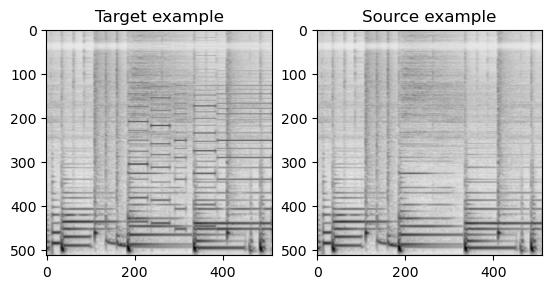

In [11]:
from riffusion.spectrogram_image_converter import SpectrogramImageConverter
from riffusion.spectrogram_params import SpectrogramParams

from utils.riffusion_utils import audio_array_to_image

target_spectrogram = audio_array_to_image(target_arr, 
                                  save_img=True,
                                  outpath="target_spectrogram_test",
                                  sample_rate=fs,
                                  device="cpu",
                                  )

source_spectrogram = audio_array_to_image(source_arr, 
                                  save_img=False,
                                  outpath="",
                                  sample_rate=fs,
                                  device="cpu",
                                  )
source_spectrogram = np.asarray(source_spectrogram)

plt.subplot(1,2,1)
plt.imshow(target_spectrogram)
plt.title("Target example")
plt.subplot(1,2,2)
plt.imshow(source_spectrogram)
plt.title("Source example")
plt.show()

In [12]:
# TODO: add control modules